In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg

# Start Spark
spark = SparkSession.builder.appName("MidMarksAnalysis").getOrCreate()
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [46]:
# Load CSV
df = spark.read.csv("MIDMARKS.csv", header=True, inferSchema=True)

print("Spark Schema:")
df.printSchema()

# Convert to Pandas
pdf = df.toPandas()
print("Columns:", pdf.columns.tolist())
pdf.head()


Spark Schema:
root
 |-- S.NO: integer (nullable = true)
 |-- SECTION: string (nullable = true)
 |-- DV: string (nullable = true)
 |-- M-II: string (nullable = true)
 |-- PP: string (nullable = true)
 |-- BEEE: string (nullable = true)
 |-- FL: string (nullable = true)
 |-- FIMS: string (nullable = true)

Columns: ['S.NO', 'SECTION', 'DV', 'M-II', 'PP', 'BEEE', 'FL', 'FIMS']


,S.NO,SECTION,DV,M-II,PP,BEEE,FL,FIMS
0,1,ALPHA,12,0,17,9,19,15
1,2,ALPHA,19,12,16,16,18,3
2,3,ALPHA,18,14,18,18,18,16
3,4,ALPHA,15,9,19,17,19,15
4,5,ALPHA,18,17,19,19,20,18


In [47]:
# Subjects are separate columns → melt into long format
subjects = ["M-II", "PP", "BEEE", "FL", "FIMS"]

long_df = pdf.melt(id_vars=["S.NO", "SECTION", "DV"], 
                   value_vars=subjects, 
                   var_name="Subject", 
                   value_name="Marks")

display(long_df.head())


,S.NO,SECTION,DV,Subject,Marks
0,1,ALPHA,12,M-II,0
1,2,ALPHA,19,M-II,12
2,3,ALPHA,18,M-II,14
3,4,ALPHA,15,M-II,9
4,5,ALPHA,18,M-II,17


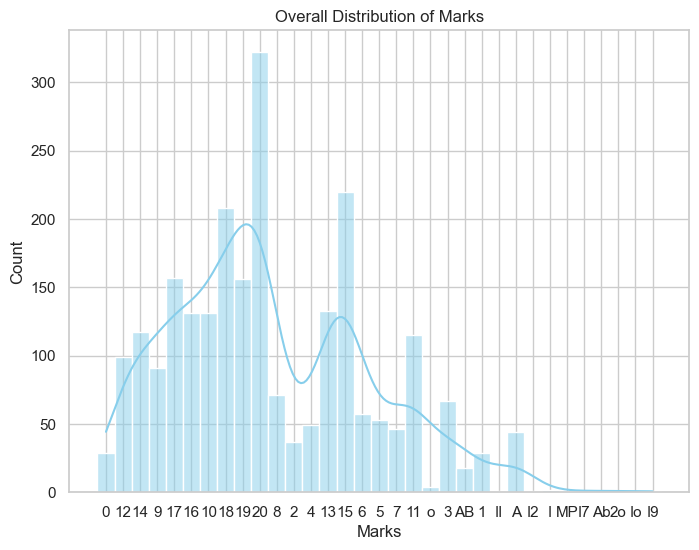

Observation:
   Shows the overall spread of marks across all subjects. Peaks indicate common scoring ranges. Skewness shows if most students scored high or low. Outliers may exist.

 Suggestion:
   Focus on students in the lower scoring ranges. Provide extra practice or revision for them.


In [48]:
# 4th Analysis: Overall Distribution of Marks
plt.figure(figsize=(8,6))
sns.histplot(long_df["Marks"].dropna(), bins=20, kde=True, color="skyblue")
plt.title("Overall Distribution of Marks")
plt.xlabel("Marks")
plt.ylabel("Count")
plt.show()

# Observation + Suggestion
cell_name = "Cell 4 - Distribution of Marks"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    print(f" Suggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


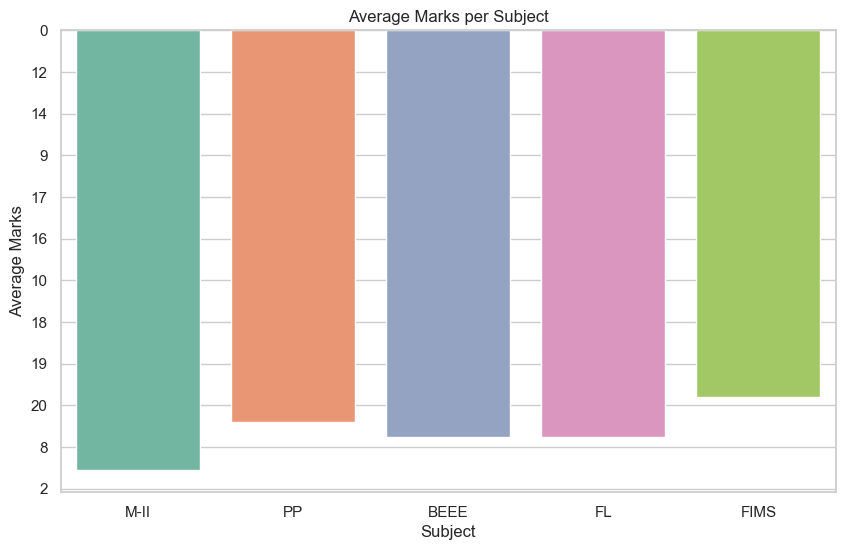

Observation:
   Compares subjects based on average marks. Higher averages indicate easier or well-understood subjects, while lower averages suggest harder topics.

Suggestion:
   Identify harder subjects and provide additional tutorials, study material, or workshops for improvement.


In [49]:
# 5th Analysis: Average Marks per Subject
plt.figure(figsize=(10,6))
sns.barplot(x="Subject", y="Marks", data=long_df, estimator=np.mean, ci=None, palette="Set2")
plt.title("Average Marks per Subject")
plt.ylabel("Average Marks")
plt.show()

# Observation + Suggestion
cell_name = "Cell 5 - Average Marks per Subject"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    print(f"Suggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


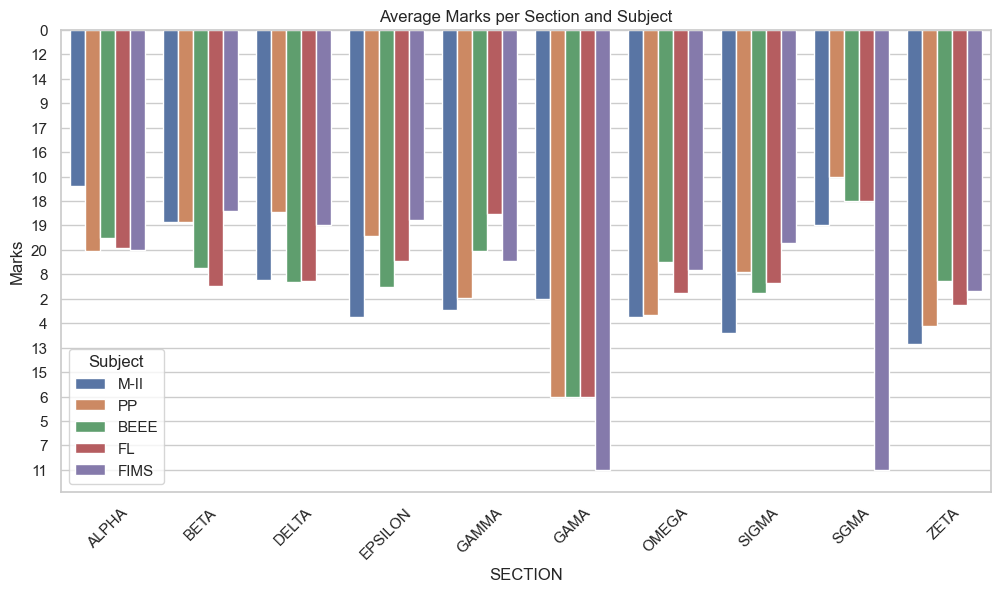

Observation:
   Compares sections across subjects. Sections scoring consistently higher may have better student aptitude or teaching methods.

Suggestion:
   Analyze teaching methods in high-performing sections and implement them in lower-performing sections.


In [50]:
# 7th Analysis: Average Marks per Section and Subject
plt.figure(figsize=(12,6))
sns.barplot(x="SECTION", y="Marks", hue="Subject", data=long_df, ci=None, estimator=np.mean)
plt.title("Average Marks per Section and Subject")
plt.xticks(rotation=45)
plt.show()

# Observation + Suggestion
cell_name = "Cell 7 - Section-wise Comparison"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    print(f"Suggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


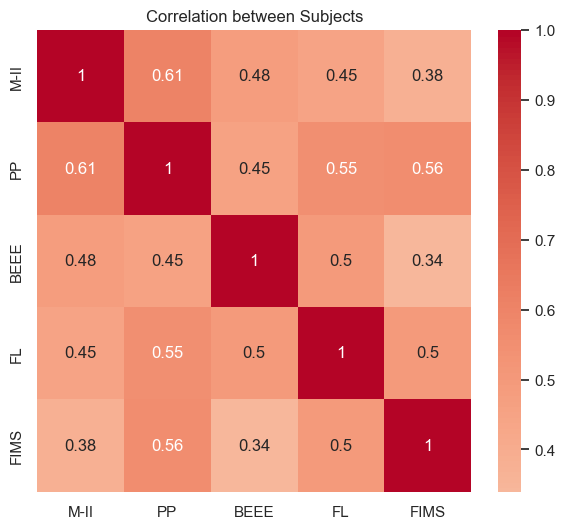

Observation:
   Shows correlation between subjects. High correlation means students perform similarly across these subjects. Low correlation indicates independent performance.

Suggestion:
   For subjects with low correlation, consider reviewing prerequisite knowledge and interlinking topics to improve performance.


In [51]:
# 8th Analysis: Correlation Heatmap of Subjects

# Convert subject columns to numeric (ignore errors -> non-numeric will become NaN)
for col in subjects:
    pdf[col] = pd.to_numeric(pdf[col], errors='coerce')

# Drop rows where all subjects are NaN
pdf = pdf.dropna(subset=subjects, how='all')

# Generate correlation heatmap
plt.figure(figsize=(7,6))
sns.heatmap(pdf[subjects].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Subjects")
plt.show()

# Observation + Suggestion
cell_name = "Cell 8 - Correlation Heatmap"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    print(f"Suggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


<Figure size 1200x600 with 0 Axes>

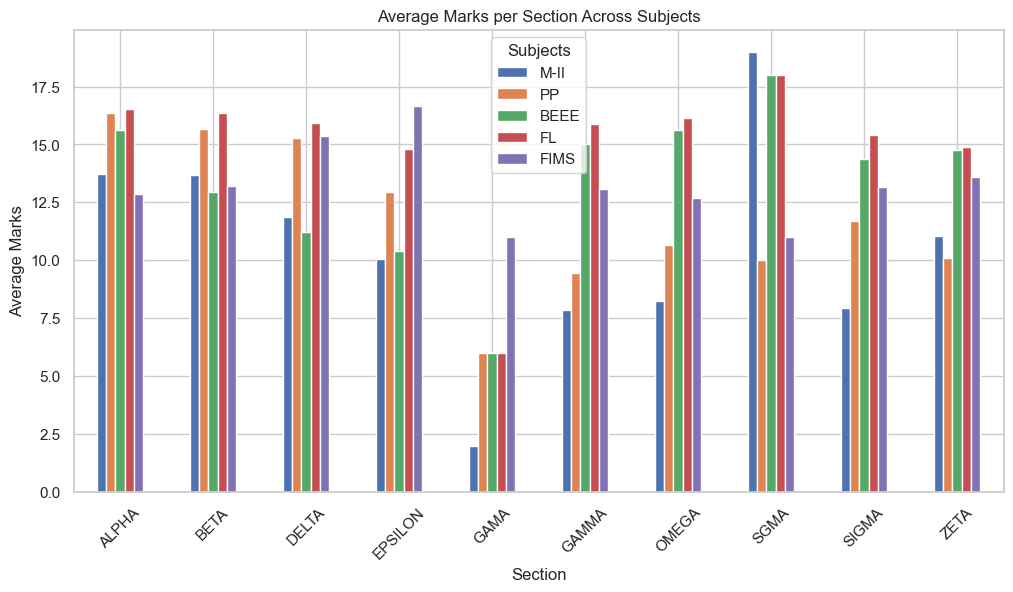

Observation:
   Highlights best and worst performing sections for each subject. Differences indicate teaching effectiveness, student aptitude, or subject difficulty.

Detailed Observations:
➡️ In M-II, Section SGMA performed best while Section GAMA performed lowest.
➡️ In PP, Section ALPHA performed best while Section GAMA performed lowest.
➡️ In BEEE, Section SGMA performed best while Section GAMA performed lowest.
➡️ In FL, Section SGMA performed best while Section GAMA performed lowest.
➡️ In FIMS, Section EPSILON performed best while Section GAMA performed lowest.

Suggestion:
   Support weaker sections with extra coaching and peer learning sessions.


In [52]:
# 9th Analysis: Average Marks per Section for Each Subject
avg_section = pdf.groupby("SECTION")[subjects].mean()

plt.figure(figsize=(12,6))
avg_section.plot(kind="bar", figsize=(12,6))
plt.title("Average Marks per Section Across Subjects")
plt.xlabel("Section")
plt.ylabel("Average Marks")
plt.legend(title="Subjects")
plt.xticks(rotation=45)
plt.show()

# Observation + Suggestion
cell_name = "Cell 9 - Average Marks per Section Across Subjects"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    
    # Dynamic observations per subject
    print("Detailed Observations:")
    for sub in subjects:
        best_section = avg_section[sub].idxmax()
        worst_section = avg_section[sub].idxmin()
        print(f"➡️ In {sub}, Section {best_section} performed best while Section {worst_section} performed lowest.")
    
    print(f"\nSuggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


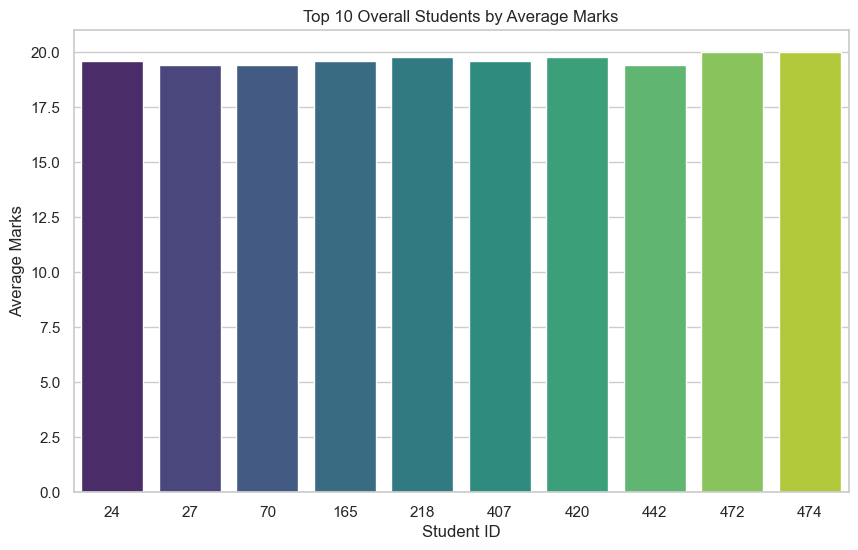

Observation:
   Shows students with highest average marks across all subjects. Highlights consistently strong performers.

Detailed Observations:
➡️ Student 474.0 has an average mark of 20.00
➡️ Student 472.0 has an average mark of 20.00
➡️ Student 420.0 has an average mark of 19.80
➡️ Student 218.0 has an average mark of 19.80
➡️ Student 165.0 has an average mark of 19.60
➡️ Student 407.0 has an average mark of 19.60
➡️ Student 24.0 has an average mark of 19.60
➡️ Student 70.0 has an average mark of 19.40
➡️ Student 27.0 has an average mark of 19.40
➡️ Student 442.0 has an average mark of 19.40

Suggestion:
   Recognize these students and provide incentives to motivate all students.


In [53]:
# Average marks per student
pdf["AvgMarks"] = pdf[subjects].mean(axis=1)

# Top 10 overall performers
top_overall = pdf[["S.NO", "AvgMarks"]].sort_values(by="AvgMarks", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x="S.NO", y="AvgMarks", data=top_overall, palette="viridis")
plt.title("Top 10 Overall Students by Average Marks")
plt.xlabel("Student ID")
plt.ylabel("Average Marks")
plt.show()

# Observation + Suggestion
cell_name = "Cell 11 - Top 10 Overall Students"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    
    # Dynamic observations for top students
    print("Detailed Observations:")
    for idx, row in top_overall.iterrows():
        print(f"➡️ Student {row['S.NO']} has an average mark of {row['AvgMarks']:.2f}")
    
    print(f"\nSuggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")


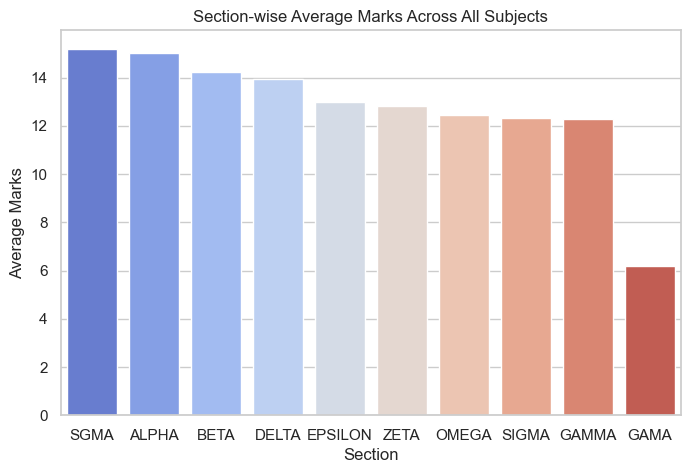

Observation:
   Compares sections based on overall average marks across all subjects. High-performing sections may reflect stronger groups.

Detailed Observations:
➡️ Section SGMA has an overall average of 15.20 marks.
➡️ Section ALPHA has an overall average of 15.02 marks.
➡️ Section BETA has an overall average of 14.23 marks.
➡️ Section DELTA has an overall average of 13.93 marks.
➡️ Section EPSILON has an overall average of 13.00 marks.
➡️ Section ZETA has an overall average of 12.81 marks.
➡️ Section OMEGA has an overall average of 12.46 marks.
➡️ Section SIGMA has an overall average of 12.34 marks.
➡️ Section GAMMA has an overall average of 12.28 marks.
➡️ Section GAMA has an overall average of 6.20 marks.

Suggestion:
   Focus on weaker sections and implement strategies from stronger sections to improve overall performance.


In [54]:
# Section-wise average across all subjects
pdf["TotalAvg"] = pdf[subjects].mean(axis=1)
section_avg = pdf.groupby("SECTION")["TotalAvg"].mean().sort_values(ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x=section_avg.index, y=section_avg.values, palette="coolwarm")
plt.title("Section-wise Average Marks Across All Subjects")
plt.xlabel("Section")
plt.ylabel("Average Marks")
plt.show()

# Observation + Suggestion
cell_name = "Cell 12 - Section-wise Overall Performance"
insight = cell_insights.get(cell_name)

if insight:
    print(f"Observation:")
    print(f"   {insight['observation']}\n")
    
    # Dynamic observations per section
    print("Detailed Observations:")
    for sec, avg_mark in section_avg.items():
        print(f"➡️ Section {sec} has an overall average of {avg_mark:.2f} marks.")
    
    print(f"\nSuggestion:")
    print(f"   {insight['suggestion']}")
else:
    print(f"No insights available.")
